# ULMFit with FastAI

Large part of FastAis NLP course is dedicated to the Universal Language Model Fine-tuning (ULMFit) approach. Which summarized is a three step process:
- Decide on a pretrained language model, in this case an RNN pretrained on Wikipedia.
- Fine-tune that language model on a more specific corpus, corpus being dataset of airline tweets.
- Use that language model as prerequisite for fine-tuning a classification model with the same specific corpus. 

This should result in a better end result that skipping any of the steps. 

In [1]:
#collapse
from fastai.text.all import *
from fastai.text import *
import pandas as pd
import numpy as np
from pathlib import Path

# Data exploration

Stared with downloading and familiarizing my self with the dataset. 

In [2]:
df_check = pd.read_csv(r"../datasets/Tweets.csv.zip", nrows=10)
df_check.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Started with looking at a few data points to get a little overview, and can from this see that the class label is airline_sentiment which is expressed as a string (or object), the airline review is contained under the header text. 

In [3]:
df_all = pd.read_csv("../datasets/Tweets.csv.zip")
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [4]:
#collapse
# Wanted to make sure that none of the sentiments were nan.
df_all["airline_sentiment"].isna().sum()

0

In [5]:
df_all["airline_sentiment"].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

The dataset has 14640 entries, and neither airline_sentiment nor text seems to lack any. However, it is splint into three different classes negative, neutral and positive. Something noteworthy is that the dataset contains lots more negative reviews. As such, it could be interesting to see if the dataset has other skewed distributions and try to see how represented the different airlines are.

In [6]:
df_all["airline"].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

Only kept the text and sentiment column, and also renamed it to label.

In [7]:
df = df_all[["airline_sentiment","text"]].copy()
df.rename(columns={"airline_sentiment":"label"}, inplace=True)               

An is_valid column signals to the DataBlock which parts of the dataset is validation and which is training. So created 20% validation data. 

In [8]:
np.random.seed(2020)
df["is_valid"]=np.random.choice([True, False], len(df), p=[0.8,0.2 ])

# Language Model

Tokenization and numericalization of the dataset is something which must be considered. Tokenization being the part where the corpus is broken down to tokens, which are used to represent the text. Furthermore, since models rely on numerical data, the tokens has to be given an number. Passing a TextBlock to a Datablock in FastAi handels both the tokenization and numericalization of the data. DataBlock is then used to create the DataLoader. Then fastai's pretrained language model is fine-tuned on the Twitter dataset. 

In [9]:
tweet_lm = DataBlock(blocks=TextBlock.from_df("text", is_lm=True),
                    get_x=ColReader("text"),
                    splitter=ColSplitter())

In [10]:
tweet_lm = tweet_lm.dataloaders(df, bs=16, seq_len=72)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


In [11]:
tweet_lm.show_batch(max_n=5)

,text,text_
0,"xxbos @jetblue xxmaj spent most of the winter in xxup xxunk with xxmaj mom , jetblue will take me home to xxup fl via xxup bos on xxmaj mon . xxmaj miss hubby , xxunk , warm # xxunk xxbos @southwestair want to explain why i was on hold for 2 + hrs tonight trying to reach customer service only to learn they 're only there mon - fr ? xxbos @united","@jetblue xxmaj spent most of the winter in xxup xxunk with xxmaj mom , jetblue will take me home to xxup fl via xxup bos on xxmaj mon . xxmaj miss hubby , xxunk , warm # xxunk xxbos @southwestair want to explain why i was on hold for 2 + hrs tonight trying to reach customer service only to learn they 're only there mon - fr ? xxbos @united xxup"
1,"when i made a xxmaj united weather change , free / 5 min . xxmaj you guys 2 hrs on hold & & $ 25 . xxbos @americanair ; @usairways xxup us 728 / xxmaj feb 21 . xxmaj unprofessional , xxunk , xxunk , xxunk communication , and xxunk solutions . xxbos @jetblue i would drive 2 1 / 2 hours to jfk to board jetblue to xxmaj vegas instead of","i made a xxmaj united weather change , free / 5 min . xxmaj you guys 2 hrs on hold & & $ 25 . xxbos @americanair ; @usairways xxup us 728 / xxmaj feb 21 . xxmaj unprofessional , xxunk , xxunk , xxunk communication , and xxunk solutions . xxbos @jetblue i would drive 2 1 / 2 hours to jfk to board jetblue to xxmaj vegas instead of closer"
2,"xxbos @southwestair are xxunk that the xxunk "" , xxunk xxunk free or xxunk are automatically $ 75 / each way ? xxmaj the xxup xxunk page is n't very clear to me . xxbos @united it was delivered ! xxmaj thank you for making sure it arrived at my xxunk ! xxbos @americanair xxunk on the terminal , what ' the best option ? xxmaj arrive xxup c , depart xxup","@southwestair are xxunk that the xxunk "" , xxunk xxunk free or xxunk are automatically $ 75 / each way ? xxmaj the xxup xxunk page is n't very clear to me . xxbos @united it was delivered ! xxmaj thank you for making sure it arrived at my xxunk ! xxbos @americanair xxunk on the terminal , what ' the best option ? xxmaj arrive xxup c , depart xxup xxunk"
3,"tv 's xxunk xxmaj xxunk xxmaj xxunk . xxmaj tough to xxunk that quickly . xxmaj not a complaint , just an xxunk . xxbos @jetblue loved the service from the staff at xxmaj newark today . \n\n xxmaj good service goes along way . \n\n i appreciate your xxunk \n\n xxmaj nj ✈ xxunk \n\n▁ xxrep 3 xxunk xxbos @virginamerica xxmaj well , i xxunk … but xxup now i xxup","'s xxunk xxmaj xxunk xxmaj xxunk . xxmaj tough to xxunk that quickly . xxmaj not a complaint , just an xxunk . xxbos @jetblue loved the service from the staff at xxmaj newark today . \n\n xxmaj good service goes along way . \n\n i appreciate your xxunk \n\n xxmaj nj ✈ xxunk \n\n▁ xxrep 3 xxunk xxbos @virginamerica xxmaj well , i xxunk … but xxup now i xxup do"
4,a call back feature ! xxbos “ @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / xxunk ” + lol wow xxbos @united xxmaj i 'm not know if the seats are actually xxunk than other seats but they feel like it . xxmaj or maybe xxmaj i 'm extra xxunk . xxbos @united you 'd learn if you listen to your customers … you do,call back feature ! xxbos “ @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / xxunk ” + lol wow xxbos @united xxmaj i 'm not know if the seats are actually xxunk than other seats but they feel like it . xxmaj or maybe xxmaj i 'm extra xxunk . xxbos @united you 'd learn if you listen to your customers … you do want


In [12]:
learn_lm = language_model_learner(tweet_lm, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()]).to_fp16()

In [13]:
learn_lm.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.161669,5.874311,0.159417,355.779419,00:15
1,5.595076,5.006215,0.192024,149.338440,00:11
2,4.914672,4.457724,0.215060,86.290855,00:11
3,4.390341,4.201617,0.240306,66.794266,00:11
4,4.096628,4.130862,0.247976,62.231560,00:12
5,3.926286,4.094766,0.251335,60.025272,00:11
6,3.816551,4.074054,0.253584,58.794819,00:12
7,3.750387,4.064131,0.254351,58.214314,00:11
8,3.703751,4.060599,0.254894,58.009068,00:11
9,3.677141,4.060071,0.254925,57.978401,00:11


In [14]:
#collapse
learn_lm.save_encoder("finetuned")

In [15]:
#collapse
#learn_lm.save('10epoch_lm')

# Classification
A DataBlock is created for the classification fine-turning. Here the vocab created for the language model is passed along, which makes the token match the index, and lets the models work together. Then a DataLoader is created. As with above, the batch shows that the text is tokenized. An text_classifier_learner crated and the previously saved encoder is loaded in. When training the classification model FastAi suggests gradual unfreezing the model and discriminative learning rates. I first tried without that approach and got an accuracy of 76.98% accuracy, which was worse than the results shown bellow of an accuracy of 78.97% accuracy. The confusion matrix shows that the model is really good at predicting negative tweets, but lack the same understanding of neutral and positive. As such, 829 of the tweets label neutral was labeled negative. The relative small dataset, and the skewed distribution of labels might be some reasons.

In [16]:
tweet_clas = DataBlock(blocks=(TextBlock.from_df("text", seq_len=72, vocab=tweet_lm.vocab), CategoryBlock), 
                       get_x=ColReader("text"), 
                       get_y=ColReader("label"),
                       splitter=ColSplitter())

In [17]:
tweet_clas = tweet_clas.dataloaders(df, bs=16)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [18]:
tweet_clas.show_batch(max_n=5)

,text,category
0,xxbos @usairways xxup plans xxup changed ! xxup is xxup that xxup what u xxup call xxup not xxup xxunk xxup able 2 xxup park xxup on xxup time xxup planes w a 2 xxup hr xxup layover n b xxup able 2 xxup make xxup ur xxup connection ! # seriously,negative
1,"xxbos @usairways e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx !",positive
2,xxbos @united xxup fail xxmaj you xxmaj cancelled xxmaj flightled our flight frm xxup xxunk and then used our reserv home to xxup iah ( from xxup sea ) for reflight xxmaj booking xxmaj problems w / out xxup our xxup xxunk ! ! # xxup xxunk,negative
3,xxbos @united : xxmaj unhappy with xxmaj united 's service ? \n\n xxmaj read xxmaj xxunk xxmaj xxunk 's open letter to ual 's xxup ceo . \n\n xxmaj leave a comment or xxup rt . \n\n http : / / t.co / xxunk,negative
4,xxbos @southwestair xxmaj thx for the xxup grand view today ! xxup flt xxunk xxup seatac to xxup phx . # xxunk # xxmaj arizona # xxmaj wow # xxmaj love # xxmaj photography http : / / t.co / xxunk,positive


In [19]:
learn_clas = text_classifier_learner(tweet_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

In [20]:
#collapse
learn_clas = learn_clas.load_encoder("finetuned")

In [21]:
learn_clas.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.799796,0.627124,0.739082,00:20


In [22]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.725965,0.618923,0.734220,00:21


In [23]:
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.664376,0.550634,0.781218,00:20


In [24]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.527189,0.525152,0.792136,00:21
1,0.472593,0.530672,0.791027,00:21


In [25]:
#collapse 
# As mentioned I did try this first
# learn_clas.fit_one_cycle(10, 2e-2)

In [26]:
learn_clas.show_results()

,text,category,category_
0,xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - jac 29 / 9 xxup jac - lax 8 / 10 xxup lax - dub 13 / 10 . xxmaj i 'm * xxunk xxmaj what is checked bag allowance for xxup jac - lax ?,neutral,negative
1,"xxbos @usairways 4 segments , 4 / 4 delayed . xxmaj gnv > xxup ctl . xxup ctl > xxup jan . xxup jan > xxup ctl . xxup ctl > xxup gnv . xxmaj my year off from flying with you guys was the way to go .",negative,negative
2,"xxbos @united xxup xxunk from xxup ric , xxup xxunk from xxup ord , & & xxup xxunk from xxup den xxunk xxup delayed for non - weather issues . xxmaj way to go , you re batting 1 . xxrep 3 0 ! xxmaj but no hotels",negative,negative
3,"xxbos xxmaj can i put sun in my carry on ? xxup rt “ @united : xxunk xxrep 3 e xxmaj right now 0 would be a heat xxunk , so enjoy the warmth ! xxmaj can you bring some home ? xxunk ”",neutral,neutral
4,"xxbos @united ( 2 / 2 ) xxmaj it xxunk that if ca n't confirm cert at time of xxmaj flight xxmaj booking xxmaj problems , i should assume that it may never clear . xxmaj did n't used to be that way",negative,negative
5,xxbos @americanair xxmaj yes i am . xxunk / xxunk . xxup rno departure at xxunk on 2 / 25 w / connection at xxup dfw to xxup lga . i can do the xxunk to xxup lax and then to xxup jfk,negative,neutral
6,"xxbos @southwestair - xxmaj hi . xxmaj my flight confirmation # is xxunk . xxmaj we are currently stuck in xxmaj norfolk , xxmaj va . xxmaj trying to get to xxup lga in xxup nyc . xxmaj xxunk updates ? xxmaj thx",negative,neutral
7,"xxbos @united booked award tix on xxunk but xxmaj i 'm not seeing a conf # for them , just the xxmaj united xxmaj flight xxmaj booking xxmaj problems # . xxmaj can you get get the xxmaj xxunk # for me ?",neutral,neutral
8,xxbos @usairways if you get my bag from e xxmaj gate to b xxmaj gate at the xxmaj charlotte airport before my 6 pm flight ( late xxmaj flight cause of y all ) xxmaj i ’ll ride xxup us for life,negative,negative


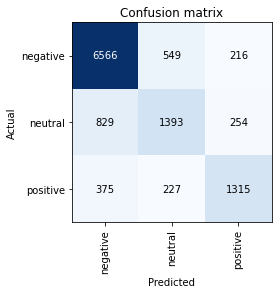

In [27]:
interp = ClassificationInterpretation.from_learner(learn_clas)
interp.plot_confusion_matrix()

In [29]:
#collapse 
learn_clas.predict("I really loved that flight, it was awesome!")

('positive', TensorText(2), TensorText([0.0047, 0.0024, 0.9929]))

In [30]:
#collapse 
#learn_clas.save('10epoch_clas')